## GEO 885 Project data processing 

### Load packages

In [1]:
import requests
import pandas as pd
import json
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
import shapely
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

C:\Users\wlq92\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\wlq92\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Load data

In [2]:
data_path = "C:/Users/wlq92/Desktop/UZH/FS 2024/Geo 885 Project/traffic_axis_json/data/vas.vas_tempo_ist_event.json"
traffic_axis_full = gpd.read_file(data_path)
accident_path = "https://data.stadt-zuerich.ch/dataset/sid_dav_strassenverkehrsunfallorte/download/RoadTrafficAccidentLocations.json"
accident = gpd.read_file(accident_path)
noise_path = "C:/Users/wlq92/Desktop/UZH/FS 2024/Geo 885 Project/noise_json/data/ugz.lbk_emissionsabschnitt.json"
noise = gpd.read_file(noise_path)

In [3]:
traffic_axis_full.head()

ausnahmen_fahrverbot fahrverbot_ssv lokalisationsname  objectid  \
0                 None           None                A1         1   
1                 None           None                A1         2   
2                 None           None                A1         3   
3                 None           None                A1         4   
4                 None           None                A1         5   

  publiziert_vsi_datum rechtskraeftig_datum temporegime temporegime_technical  \
0                 None                 None        T100                  T100   
1                 None                 None        T120                  T120   
2                 None                 None        T120                  T120   
3                 None                 None        T100                  T100   
4                 None                 None        T120                  T120   

  umgesetzt_datum                                           geometry  
0            None  LINESTRING (8.55325 47.42881, 8.55452 47.42814...  
1            None  LINESTRING (8.54305 47.43252, 8.54432 47.43222...  
2            None  LINESTRING (8.51635 47.43167, 8.51525 47.43132...  
3            None  LINESTRING (8.55637 47.42739, 8.55615 47.42749...  
4            None  LINESTRING (8.55340 47.42892, 8.55340 47.42892...

### Accident data

In [5]:
columns_to_drop = ['AccidentType_de', 'AccidentType_fr', 'AccidentType_it', 'AccidentSeverityCategory_de', 'AccidentSeverityCategory_fr', 'AccidentSeverityCategory_it', 'RoadType_de', 'RoadType_fr', 'RoadType_it', 'AccidentMonth_de', 'AccidentMonth_fr', 'AccidentMonth_it', 'AccidentWeekDay_de', 'AccidentWeekDay_fr', 'AccidentWeekDay_it']
accident = accident.drop(columns=columns_to_drop, axis=1)
accident.head()
#accident.columns.values.tolist()
#len(accident) #61058

AccidentUID AccidentType  \
0  9FC221265B5EE0F0E0430A865E33E0F0          at0   
1  9FC221265E13E0F0E0430A865E33E0F0          at7   
2  9FC22126601FE0F0E0430A865E33E0F0          at3   
3  9FC22126614DE0F0E0430A865E33E0F0          at2   
4  9FC2212663A3E0F0E0430A865E33E0F0          at7   

                           AccidentType_en AccidentSeverityCategory  \
0  Accident with skidding or self-accident                      as4   
1                    Accident when parking                      as4   
2      Accident when turning left or right                      as4   
3         Accident with rear-end collision                      as4   
4                    Accident when parking                      as4   

     AccidentSeverityCategory_en AccidentInvolvingPedestrian  \
0  Accident with property damage                       false   
1  Accident with property damage                       false   
2  Accident with property damage                       false   
3  Accident with property damage                       false   
4  Accident with property damage                       false   

  AccidentInvolvingBicycle AccidentInvolvingMotorcycle RoadType  \
0                    false                       false    rt433   
1                    false                       false    rt433   
2                    false                       false    rt433   
3                    false                       false    rt432   
4                    false                       false    rt439   

      RoadType_en  ... CantonCode MunicipalityCode AccidentYear AccidentMonth  \
0      Minor road  ...         ZH             0261         2011             1   
1      Minor road  ...         ZH             0261         2011             1   
2      Minor road  ...         ZH             0261         2011             1   
3  Principal road  ...         ZH             0261         2011             1   
4           Other  ...         ZH             0261         2011             1   

  AccidentMonth_en AccidentWeekDay AccidentWeekDay_en AccidentHour  \
0          January           aw405             Friday           08   
1          January           aw406           Saturday           17   
2          January           aw404           Thursday           10   
3          January           aw404           Thursday           13   
4          January           aw403          Wednesday           10   

  AccidentHour_text                            geometry  
0           08h-09h  POINT Z (8.53227 47.35797 0.00000)  
1           17h-18h  POINT Z (8.52673 47.38581 0.00000)  
2           10h-11h  POINT Z (8.53017 47.33881 0.00000)  
3           13h-14h  POINT Z (8.53885 47.41327 0.00000)  
4           10h-11h  POINT Z (8.54664 47.42706 0.00000)  

[5 rows x 22 columns]

### Traffic axis 
Filter the axis that implemented after year 2011.
Filter the speed limit to T30

In [6]:
traffic_axis_full["implemented_year"] = traffic_axis_full["umgesetzt_datum"].str[:4]
traffic_axis_full["implemented_month"] = traffic_axis_full["umgesetzt_datum"].str[4:6]
traffic_axis_full["implemented_YYYYMM"] = traffic_axis_full["umgesetzt_datum"].str[:6]

traffic_axis = traffic_axis_full[traffic_axis_full["umgesetzt_datum"].notnull()]
traffic_axis = traffic_axis[traffic_axis["implemented_year"].astype(int) >= 2011]

traffic_axis_T30 = traffic_axis[traffic_axis["temporegime_technical"] == "T30"]
traffic_axis_T20 = traffic_axis[traffic_axis["temporegime_technical"] == "T20"]
traffic_axis_T50 = traffic_axis[traffic_axis["temporegime_technical"] == "T50"]

traffic_axis_T50 #148
#len(traffic_axis) #561 
#len(traffic_axis_T30) #303

ausnahmen_fahrverbot fahrverbot_ssv     lokalisationsname  objectid  \
174                  None           None        Allmendstrasse       175   
297                  None           None           Asylstrasse       302   
382                  None           None        Badenerstrasse       382   
581                  None           None  Birmensdorferstrasse       573   
828                  None           None         Börsenstrasse       817   
1070                 None           None    Emil-Klöti-Strasse      1062   
1072                 None           None    Emil-Klöti-Strasse      1064   
1174                 None           None          Europabrücke      1161   
1275                 None           None   Frankentalerstrasse      1256   
1410                 None           None   General-Guisan-Quai      1405   
1490                 None           None       Glaubtenstrasse      1474   
2866                 None           None            Mythenquai      2851   
2867                 None           None            Mythenquai      2852   
3231                 None           None   Regensdorferstrasse      3222   
3522                 None           None    Schauenbergstrasse      3516   
3707                 None           None            Seestrasse      3700   
3790                 None           None           Soodstrasse      3777   
3792                 None           None           Soodstrasse      3779   
4028                 None           None      Thurgauerstrasse      4045   
4038                 None           None      Thurgauerstrasse      4046   
4208                 None           None      Ueberlandstrasse      4194   
4364                 None           None      Wehntalerstrasse      4363   

     publiziert_vsi_datum rechtskraeftig_datum temporegime  \
174                  None                 None         T50   
297                  None                 None         T50   
382                  None                 None         T50   
581                  None                 None         T50   
828                  None                 None         T50   
1070                 None                 None         T50   
1072                 None                 None         T50   
1174                 None                 None         T50   
1275                 None                 None         T50   
1410                 None                 None         T50   
1490                 None                 None         T50   
2866                 None                 None         T50   
2867                 None                 None         T50   
3231                 None                 None         T50   
3522                 None                 None         T50   
3707                 None                 None         T50   
3790                 None                 None         T50   
3792                 None                 None         T50   
4028                 None                 None         T50   
4038                 None                 None         T50   
4208                 None                 None         T50   
4364                 None                 None         T50   

     temporegime_technical umgesetzt_datum  \
174                    T50  20170106000000   
297                    T50  20161219000000   
382                    T50  20161024000000   
581                    T50  20161001000000   
828                    T50  20161219000000   
1070                   T50  20190820000000   
1072                   T50  20190820000000   
1174                   T50  20161024000000   
1275                   T50  20190605000000   
1410                   T50  20170106000000   
1490                   T50  20190820000000   
2866                   T50  20170106000000   
2867                   T50  20170106000000   
3231                   T50  20170331000000   
3522                   T50  20200714000000   
3707                   T50  20170106000000   
3790                   T50  20170106000000   
3

Get the buffer around traffic axis (10 units)

In [7]:
traffic_axis_T30_projected = traffic_axis_T30.to_crs(epsg = 3857)
traffic_axis_T20_projected = traffic_axis_T20.to_crs(epsg = 3857)
traffic_axis_T50_projected = traffic_axis_T50.to_crs(epsg = 3857)

buffer_zone = 10
traffic_axis_T30_buffer = traffic_axis_T30_projected.geometry.buffer(buffer_zone)
traffic_axis_T20_buffer = traffic_axis_T20_projected.geometry.buffer(buffer_zone)
traffic_axis_T50_buffer = traffic_axis_T50_projected.geometry.buffer(buffer_zone)

buffer_T30_gdf = gpd.GeoDataFrame(geometry = traffic_axis_T30_buffer, crs = traffic_axis_T30_projected.crs)
buffer_T30_gdf["implemented_year"] = traffic_axis_T30["implemented_year"]
buffer_T30_gdf["implemented_month"] = traffic_axis_T30["implemented_month"]
buffer_T30_gdf["implemented_YYYYMM"] = traffic_axis_T30["implemented_YYYYMM"]

buffer_T20_gdf = gpd.GeoDataFrame(geometry = traffic_axis_T20_buffer, crs = traffic_axis_T20_projected.crs)
buffer_T20_gdf["implemented_YYYYMM"] = traffic_axis_T20["implemented_YYYYMM"]

buffer_T50_gdf = gpd.GeoDataFrame(geometry = traffic_axis_T50_buffer, crs = traffic_axis_T50_projected.crs)
buffer_T50_gdf["implemented_YYYYMM"] = traffic_axis_T50["implemented_YYYYMM"]

buffer_T50_gdf.head()
#traffic_axis_T30_buffer.columns.values.tolist()
#buffer_T30_gdf["implemented_year"].min()
#buffer_T30_gdf["implemented_year"].value_counts()

geometry implemented_YYYYMM
174  POLYGON ((948353.034 5997502.575, 948355.781 5...             201701
297  POLYGON ((952600.138 6002567.517, 952600.544 6...             201612
382  POLYGON ((943723.104 6006274.373, 943715.242 6...             201610
581  POLYGON ((944434.637 6002407.917, 944434.480 6...             201610
828  POLYGON ((950654.445 6002320.466, 950580.776 6...             201612

Join accidents to buffered traffic axis

In [8]:
#traffic_axis_T30_buffer_gdf = gpd.GeoDataFrame(geometry = traffic_axis_T30_buffer, crs = 3857)
accident_3857 = accident.to_crs(epsg=3857)
accidents_within_buffer = gpd.sjoin(accident_3857, buffer_T30_gdf, how = "inner", predicate = "intersects")

accidents_within_buffer_T20 = gpd.sjoin(accident_3857, buffer_T20_gdf, how = "inner", predicate = "intersects")
accidents_within_buffer_T50 = gpd.sjoin(accident_3857, buffer_T50_gdf, how = "inner", predicate = "intersects")

accidents_within_buffer
#len(accidents_within_buffer) #19095
accidents_within_buffer_T50.columns.values.tolist()
#accidents_within_buffer["implemented_year"].min()

['AccidentUID',
 'AccidentType',
 'AccidentType_en',
 'AccidentSeverityCategory',
 'AccidentSeverityCategory_en',
 'AccidentInvolvingPedestrian',
 'AccidentInvolvingBicycle',
 'AccidentInvolvingMotorcycle',
 'RoadType',
 'RoadType_en',
 'AccidentLocation_CHLV95_E',
 'AccidentLocation_CHLV95_N',
 'CantonCode',
 'MunicipalityCode',
 'AccidentYear',
 'AccidentMonth',
 'AccidentMonth_en',
 'AccidentWeekDay',
 'AccidentWeekDay_en',
 'AccidentHour',
 'AccidentHour_text',
 'geometry',
 'index_right',
 'implemented_YYYYMM']

In [8]:
#noise.head()

Determine accidents according to the year/month (1 year before and after)

In [9]:
def reference_date_1before (row):
    ref_date = str(int(row["implemented_YYYYMM"]) - 100)
    #ref_month = int(row["implemented_month"])
    return datetime.datetime(int(ref_date[:4]), int(ref_date[4:6]), 1).strftime('%Y-%m')

def reference_date_1after (row):
    ref_date = str(int(row["implemented_YYYYMM"]) + 100)
    #ref_month = int(row["implemented_month"])
    return datetime.datetime(int(ref_date[:4]), int(ref_date[4:6]), 1).strftime('%Y-%m')

def get_accident_date (row):
    accident_date = str(row['AccidentYear']) + str(row['AccidentMonth'])
    if len(accident_date) < 6:
        accident_date = accident_date[:4] + '0' + accident_date[4:]
    return datetime.datetime(int(accident_date[:4]), int(accident_date[4:6]), 1).strftime('%Y-%m')

def format_implementdate (row):
    implemented_date = datetime.datetime(int(row['implemented_YYYYMM'][:4]), int(row['implemented_YYYYMM'][4:6]), 1).strftime('%Y-%m')
    return implemented_date

accidents_within_buffer["ref_date"] = accidents_within_buffer.apply(reference_date_1before, axis = 1)
accidents_within_buffer["accident_date"] = accidents_within_buffer.apply(get_accident_date, axis = 1)
accidents_within_buffer["implemented_date"] = accidents_within_buffer.apply(format_implementdate, axis = 1)
accidents_within_buffer["ref_date_after"] = accidents_within_buffer.apply(reference_date_1after, axis = 1)

accidents_within_buffer_T20["ref_date"] = accidents_within_buffer_T20.apply(reference_date_1before, axis = 1)
accidents_within_buffer_T20["accident_date"] = accidents_within_buffer_T20.apply(get_accident_date, axis = 1)
accidents_within_buffer_T20["implemented_date"] = accidents_within_buffer_T20.apply(format_implementdate, axis = 1)
accidents_within_buffer_T20["ref_date_after"] = accidents_within_buffer_T20.apply(reference_date_1after, axis = 1)

accidents_within_buffer_T50["ref_date"] = accidents_within_buffer_T50.apply(reference_date_1before, axis = 1)
accidents_within_buffer_T50["accident_date"] = accidents_within_buffer_T50.apply(get_accident_date, axis = 1)
accidents_within_buffer_T50["implemented_date"] = accidents_within_buffer_T50.apply(format_implementdate, axis = 1)
accidents_within_buffer_T50["ref_date_after"] = accidents_within_buffer_T50.apply(reference_date_1after, axis = 1)

accidents_within_buffer_T50

AccidentUID AccidentType  \
78     9FDA0DC48BEE6094E0430A865E336094          at0   
89     9FDA14EB15CCE08AE0430A865E33E08A          at8   
114    A2C3D39C55C2000EE0430A865E33000E          at4   
231    A5D2C4A559A1707EE0430A865E33707E          at2   
314    A64D2F745E81002AE0430A865E33002A          at0   
...                                 ...          ...   
60701  C5BC8AC1AAFB9414E053DDB9D80A1776          at0   
60804  DC226644A23D01C0E0530AB38B029441          at0   
60863  E9929F8A06620146E0530AB38B02E926          at2   
60915  F6C44BE3E43301F6E0530AB38B02F3AD          at0   
60981  0C3833E1BF5401A0E0630AB38B02D7BB          at0   

                               AccidentType_en AccidentSeverityCategory  \
78     Accident with skidding or self-accident                      as4   
89            Accident involving pedestrian(s)                      as2   
114       Accident when turning-into main road                      as3   
231           Accident with rear-end collision                      as3   
314    Accident with skidding or self-accident                      as2   
...                                        ...                      ...   
60701  Accident with skidding or self-accident                      as3   
60804  Accident with skidding or self-accident                      as3   
60863         Accident with rear-end collision                      as4   
60915  Accident with skidding or self-accident                      as4   
60981  Accident with skidding or self-accident                      as4   

         AccidentSeverityCategory_en AccidentInvolvingPedestrian  \
78     Accident with property damage                       false   
89     Accident with severe injuries                        true   
114     Accident with light injuries                       false   
231     Accident with light injuries                       false   
314    Accident with severe injuries                       false   
...                              ...                         ...   
60701   Accident with light injuries                       false   
60804   Accident with light injuries                       false   
60863  Accident with property damage                       false   
60915  Accident with property damage                       false   
60981  Accident with property damage                       false   

      AccidentInvolvingBicycle AccidentInvolvingMotorcycle RoadType  \
78                       false                       false    rt433   
89                       false                       false    rt432   
114                      false                       false    rt432   
231                      false                       false    rt432   
314                       true                       false    rt432   
...                        ...                         ...      ...   
60701                     true                       false    rt432   
60804                     true                       false    rt432   
60863                    false                       false    rt432   
60915                    false                       false    rt433   
60981                    false                       false    rt433   

          RoadType_en  ... AccidentWeekDay_en AccidentHour AccidentHour_text  \
78         Minor road  ...          Wednesday           23           23h-00h   
89     Principal road  ...           Thursday           17           17h-18h   
114    Principal road  ...           Saturday           06           06h-07h   
231    Principal road  ...           Saturday           12           12h-13h   
314    Principal road  ...             Friday           17           17h-18h   
...               ...  ...                ...          ...               ...   
60701  Principal road  ...             Friday           16           16h-17h   
60804  Principal road  ...           Thursday           08           08h-09h   
60863  Principal road  ...          Wednesday           07      

In [10]:
accidents_1year_beforeimply = accidents_within_buffer[
    (accidents_within_buffer['accident_date'] >= accidents_within_buffer['ref_date']) &
    (accidents_within_buffer['accident_date'] <= accidents_within_buffer['implemented_date'])]

accidents_1year_beforeimply_T20 = accidents_within_buffer_T20[
    (accidents_within_buffer_T20['accident_date'] >= accidents_within_buffer_T20['ref_date']) &
    (accidents_within_buffer_T20['accident_date'] <= accidents_within_buffer_T20['implemented_date'])]

accidents_1year_beforeimply_T50 = accidents_within_buffer_T50[
    (accidents_within_buffer_T50['accident_date'] >= accidents_within_buffer_T50['ref_date']) &
    (accidents_within_buffer_T50['accident_date'] <= accidents_within_buffer_T50['implemented_date'])]

accidents_1year_beforeimply_T50
#accidents_1year_beforeimply

AccidentUID AccidentType  \
4276   22C2C880914302C4E0530A839427CEA2          at2   
5623   352B33D52EE801E6E0530A839427E34A          at2   
6640   24E95DDA21D0027CE0530A839427E8F7          at2   
6754   2B9613B1FE8601BCE0530A83942740E9          at0   
6786   2F2F3A7C1BF70002E0530A8394272CAB          at0   
...                                 ...          ...   
59319  456AB523BC0501D4E0530A8394277C8A          at4   
59340  4E339FDB2074012CE0530A8394278592          at2   
60006  3AE5B9B30FA30126E0530A83942746F9          at0   
60048  4AEDB0DCBDBE003EE0530A8394271BE6          at1   
60371  8617F42F2475C2F1E05328B9D80A93AC          at2   

                                  AccidentType_en AccidentSeverityCategory  \
4276             Accident with rear-end collision                      as4   
5623             Accident with rear-end collision                      as3   
6640             Accident with rear-end collision                      as4   
6754      Accident with skidding or self-accident                      as4   
6786      Accident with skidding or self-accident                      as4   
...                                           ...                      ...   
59319        Accident when turning-into main road                      as4   
59340            Accident with rear-end collision                      as3   
60006     Accident with skidding or self-accident                      as3   
60048  Accident when overtaking or changing lanes                      as4   
60371            Accident with rear-end collision                      as4   

         AccidentSeverityCategory_en AccidentInvolvingPedestrian  \
4276   Accident with property damage                       false   
5623    Accident with light injuries                       false   
6640   Accident with property damage                       false   
6754   Accident with property damage                       false   
6786   Accident with property damage                       false   
...                              ...                         ...   
59319  Accident with property damage                       false   
59340   Accident with light injuries                       false   
60006   Accident with light injuries                       false   
60048  Accident with property damage                       false   
60371  Accident with property damage                       false   

      AccidentInvolvingBicycle AccidentInvolvingMotorcycle RoadType  \
4276                     false                       false    rt432   
5623                     false                       false    rt432   
6640                     false                       false    rt432   
6754                     false                       false    rt432   
6786                     false                       false    rt432   
...                        ...                         ...      ...   
59319                    false                       false    rt432   
59340                    false                       false    rt433   
60006                     true                       false    rt432   
60048                    false                       false    rt432   
60371                    false                       false    rt433   

          RoadType_en  ... AccidentWeekDay_en AccidentHour AccidentHour_text  \
4276   Principal road  ...             Monday           15           15h-16h   
5623   Principal road  ...            Tuesday           11           11h-12h   
6640   Principal road  ...           Saturday           10           10h-11h   
6754   Principal road  ...             Friday           18           18h-19h   
6786   Principal road  ...             Monday           06           06h-07h   
...               ...  ...                ...          ...               ...   
59319  Principal road  ...             Monday           06           06h-07h   
59340      Minor road  ...          Wednesday           11           11h-12h   
60006  Principal road  ...  

In [11]:
accidents_1year_afterimply = accidents_within_buffer[
    (accidents_within_buffer['accident_date'] >= accidents_within_buffer['implemented_date']) &
    (accidents_within_buffer['accident_date'] <= accidents_within_buffer['ref_date_after'])]

accidents_1year_afterimply_T20 = accidents_within_buffer_T20[
    (accidents_within_buffer_T20['accident_date'] >= accidents_within_buffer_T20['implemented_date']) &
    (accidents_within_buffer_T20['accident_date'] <= accidents_within_buffer_T20['ref_date_after'])]

accidents_1year_afterimply_T50 = accidents_within_buffer_T50[
    (accidents_within_buffer_T50['accident_date'] >= accidents_within_buffer_T50['implemented_date']) &
    (accidents_within_buffer_T50['accident_date'] <= accidents_within_buffer_T50['ref_date_after'])]

accidents_1year_afterimply_T50
#accidents_1year_afterimply

AccidentUID AccidentType  \
7944   440241E75B3B01BCE0530A8394278A2D          at1   
7981   501F3C1C64530158E0530A839427586D          at0   
8768   453033C98BA60098E0530A839427F4F9          at2   
9984   6770C4226CD60076E0530A839427596D          at2   
10382  47D7EDC1D42B029EE0530A839427B14B          at0   
...                                 ...          ...   
58608  9ED58877D0A61944E05329B9D80AAFC5          at0   
59340  4E339FDB2074012CE0530A8394278592          at2   
59356  53150511E2F900CCE0530A8394279980          at3   
60048  4AEDB0DCBDBE003EE0530A8394271BE6          at1   
60495  9A097C49D4C86AB5E05329B9D80AAD12          at2   

                                  AccidentType_en AccidentSeverityCategory  \
7944   Accident when overtaking or changing lanes                      as4   
7981      Accident with skidding or self-accident                      as4   
8768             Accident with rear-end collision                      as4   
9984             Accident with rear-end collision                      as4   
10382     Accident with skidding or self-accident                      as4   
...                                           ...                      ...   
58608     Accident with skidding or self-accident                      as4   
59340            Accident with rear-end collision                      as3   
59356         Accident when turning left or right                      as3   
60048  Accident when overtaking or changing lanes                      as4   
60495            Accident with rear-end collision                      as3   

         AccidentSeverityCategory_en AccidentInvolvingPedestrian  \
7944   Accident with property damage                       false   
7981   Accident with property damage                       false   
8768   Accident with property damage                       false   
9984   Accident with property damage                       false   
10382  Accident with property damage                       false   
...                              ...                         ...   
58608  Accident with property damage                       false   
59340   Accident with light injuries                       false   
59356   Accident with light injuries                       false   
60048  Accident with property damage                       false   
60495   Accident with light injuries                       false   

      AccidentInvolvingBicycle AccidentInvolvingMotorcycle RoadType  \
7944                     false                       false    rt433   
7981                     false                       false    rt432   
8768                     false                       false    rt432   
9984                     false                       false    rt432   
10382                    false                       false    rt432   
...                        ...                         ...      ...   
58608                    false                       false    rt432   
59340                    false                       false    rt433   
59356                     true                       false    rt432   
60048                    false                       false    rt432   
60495                    false                       false    rt433   

          RoadType_en  ... AccidentWeekDay_en AccidentHour AccidentHour_text  \
7944       Minor road  ...             Monday           17           17h-18h   
7981   Principal road  ...             Sunday           07           07h-08h   
8768   Principal road  ...             Friday           14           14h-15h   
9984   Principal road  ...          Wednesday           17           17h-18h   
10382  Principal road  ...             Friday           21           21h-22h   
...               ...  ...                ...          ...               ...   
58608  Principal road  ...            Tuesday           05           05h-06h   
59340      Minor road  ...          Wednesday           11           11h-12h   
59356  Principal road  ...  

In [12]:
accidents_same_year = accidents_within_buffer[accidents_within_buffer['accident_date'] == accidents_within_buffer['implemented_date']]
    
accidents_same_year
len(accidents_same_year) #50
#accidents_same_year["implemented_year"].min()
#accidents_same_year["implemented_year"].value_counts()
#accidents_same_year.columns.values.tolist()

50

### Maps

In [13]:
## T30
m = folium.Map([47.377637, 8.540391], zoom_start = 12)

buffer_layer = folium.GeoJson(data = buffer_T30_gdf,
                             popup = folium.GeoJsonPopup(fields = ["implemented_YYYYMM"]))
buffer_layer.add_to(m)

accident_before_layer = folium.GeoJson(data = accidents_1year_beforeimply,
                                marker = folium.CircleMarker(radius = 3, fill_color = "red",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_before_layer.add_to(m)

accident_after_layer = folium.GeoJson(data = accidents_1year_afterimply,
                                marker = folium.CircleMarker(radius = 3, fill_color = "orange",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_after_layer.add_to(m)

display(m)

In [14]:
## T20
m1 = folium.Map([47.377637, 8.540391], zoom_start = 12)

buffer_layer_T20 = folium.GeoJson(data = buffer_T20_gdf,
                             popup = folium.GeoJsonPopup(fields = ["implemented_YYYYMM"]))
buffer_layer_T20.add_to(m1)

accident_before_layer_T20 = folium.GeoJson(data = accidents_1year_beforeimply_T20,
                                marker = folium.CircleMarker(radius = 3, fill_color = "red",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_before_layer_T20.add_to(m1)

accident_after_layer_T20 = folium.GeoJson(data = accidents_1year_afterimply_T20,
                                marker = folium.CircleMarker(radius = 3, fill_color = "orange",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_after_layer_T20.add_to(m1)

display(m1)

In [15]:
## T50
m2 = folium.Map([47.377637, 8.540391], zoom_start = 12)

buffer_layer = folium.GeoJson(data = buffer_T50_gdf,
                             popup = folium.GeoJsonPopup(fields = ["implemented_YYYYMM"]))
buffer_layer.add_to(m2)

accident_before_layer_T50 = folium.GeoJson(data = accidents_1year_beforeimply_T50,
                                marker = folium.CircleMarker(radius = 3, fill_color = "red",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_before_layer_T50.add_to(m2)

accident_after_layer_T50 = folium.GeoJson(data = accidents_1year_afterimply_T50,
                                marker = folium.CircleMarker(radius = 3, fill_color = "orange",
                                                             fill_opacity = 0.8, color = "black", weight = 0.3),
                                popup = folium.GeoJsonPopup(fields = ["accident_date", "AccidentType_en"]))
accident_after_layer_T50.add_to(m2)

display(m2)

T-test
nornal distribution
equal variance

In [18]:

#print(accidents_1year_afterimply["AccidentSeverityCategory_en"].value_counts())
#print(accidents_1year_beforeimply["AccidentSeverityCategory_en"].value_counts())
#print(accidents_1year_afterimply["AccidentType_en"].value_counts())
#print(accidents_1year_afterimply["AccidentType"].value_counts())

severity_mapping = {
    "Accident with fatalities": 1,
    "Accident with severe injuries": 2,
    "Accident with light injuries": 3,
    "Accident with property damage": 4
}


severity_before = accidents_1year_beforeimply["AccidentSeverityCategory_en"]
severity_after = accidents_1year_afterimply["AccidentSeverityCategory_en"]

severity_before_numeric = [severity_mapping[x] for x in severity_before]
severity_after_numeric = [severity_mapping[x] for x in severity_after]

type_mapping = {
    "Accident with skidding or self-accident": 0,
    "Accident when overtaking or changing lanes": 1,
    "Accident with rear-end collision": 2,
    "Accident when turning left or right": 3,
    "Accident when turning-into main road": 4,
    "Accident when crossing the lane(s)": 5,
    "Accident with head-on collision": 6,
    "Accident when parking": 7,
    "Accident involving pedestrian(s)": 8,
    "Accident involving animal(s)": 9,
    "Other": 10
}

type_before = accidents_1year_beforeimply["AccidentType_en"]
type_after = accidents_1year_afterimply["AccidentType_en"]

type_before_numeric = [type_mapping[x] for x in type_before]
type_after_numeric = [type_mapping[x] for x in type_after]


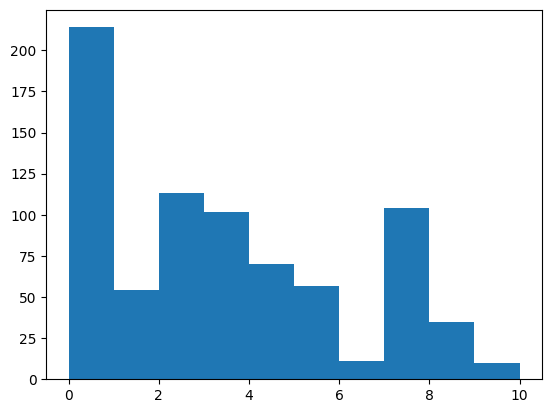

In [71]:
h1 = plt.hist(type_before_numeric)

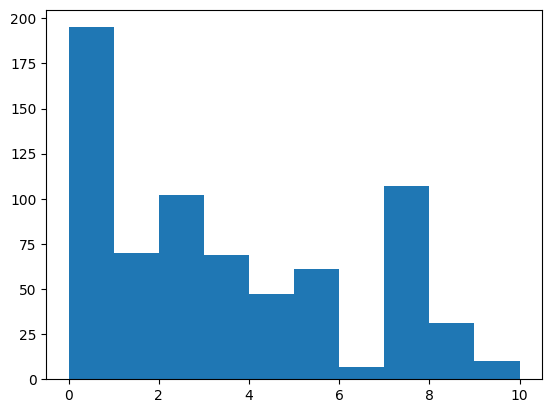

In [70]:
h2 = plt.hist(type_after_numeric)

In [62]:
t_statistic, p_value = stats.ttest_ind(severity_before_numeric, severity_after_numeric)
print("T-Statistic_s:", t_statistic)
print("P-Value_s:", p_value)

T-Statistic_s: -0.5756877510648837
P-Value_s: 0.5649145509806441


In [64]:
t_statistic_t, p_value_t = stats.ttest_ind(type_before_numeric, type_after_numeric)
print("T-Statistic_t:", t_statistic_t)
print("P-Value_t:", p_value_t)

T-Statistic_t: -0.030948690838873156
P-Value_t: 0.9753146686421484


Bike

In [30]:
#before (112)
#after (124)
accident_before_bike = accidents_1year_beforeimply[accidents_1year_beforeimply["AccidentInvolvingBicycle"] == "true"]
accident_after_bike = accidents_1year_afterimply[accidents_1year_afterimply["AccidentInvolvingBicycle"] == "true"]

In [43]:
severity_before_bike = accident_before_bike["AccidentSeverityCategory_en"]
severity_after_bike = accident_after_bike["AccidentSeverityCategory_en"]

severity_before_bike_num = [severity_mapping[x] for x in severity_before_bike]
severity_after_bike_num = [severity_mapping[x] for x in severity_after_bike]

print(severity_before_bike.value_counts())
print(severity_after_bike.value_counts())

AccidentSeverityCategory_en
Accident with light injuries     29
Accident with severe injuries     6
Accident with fatalities          1
Accident with property damage     1
Name: count, dtype: int64
AccidentSeverityCategory_en
Accident with light injuries     27
Accident with severe injuries     5
Name: count, dtype: int64


Pedestrain 

In [42]:
#before (37)
#after (32)
accident_before_p = accidents_1year_beforeimply[accidents_1year_beforeimply["AccidentInvolvingPedestrian"] == "true"]
accident_after_p = accidents_1year_afterimply[accidents_1year_afterimply["AccidentInvolvingPedestrian"] == "true"]

In [39]:
severity_before_p = accident_before_p["AccidentSeverityCategory_en"]
severity_after_p = accident_after_p["AccidentSeverityCategory_en"]

severity_before_p_num = [severity_mapping[x] for x in severity_before_p]
severity_after_p_num = [severity_mapping[x] for x in severity_after_p]

print(severity_before_p.value_counts())
print(severity_after_p.value_counts())

AccidentSeverityCategory_en
Accident with light injuries     29
Accident with severe injuries     6
Accident with fatalities          1
Accident with property damage     1
Name: count, dtype: int64
AccidentSeverityCategory_en
Accident with light injuries     27
Accident with severe injuries     5
Name: count, dtype: int64


Thoughts for further analysis
- case study
- take wider timestamp?
- road type?
- what time did the accident happen?